# Project Course: Essentials in Text and Speech Processing

## Title: Fake News Detection from Different Social Media Platforms

### Developers:
- Shaan Bhondele
- Kevin Kindler
- Levente Foldesi

## Introduction

The main goal of this project is to implement several machine learning models for the classification of fake news. These models will be trained on a specific dataset. The evaluation will focus on accuracy and other performance indicators for each machine learning model, determining their effectiveness in distinguishing between real and fake news articles.

Additionally, we will analyze cases where the models face difficulties in classification. This involves identifying features or patterns in the data that pose challenges to accurate predictions.

Finally, strategies will be implemented to enhance the robustness of the models, addressing the identified issues in the evaluation. Recommendations for further research and development in the field of fake news classification using machine learning will be provided.

## Research Questions

1. Which machine learning models are best suited for classifying fake news within the dataset used?
2. What patterns within the dataset present challenges for machine learning models to classify, and what are the reasons for these difficulties?
3. How can the models be improved to effectively classify said patterns within the dataset?

In [190]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#import torch
from transformers import AutoModel, AutoTokenizer
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, pipeline, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import datasets
from transformers import pipeline
from bs4 import BeautifulSoup
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time
import string
import emoji
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import re
from sklearn.metrics import classification_report
import eli5
from eli5.sklearn import PermutationImportance

[nltk_data] Downloading package stopwords to /Users/kevin-
[nltk_data]     kindlerhotmail.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset

The dataset can be found [here](https://zenodo.org/record/4561253/files/WELFake_Dataset.csv?download=1).

This dataset consists of four columns:

- **Index:** Index number of the news article.
- **Title:** The main heading of the news, providing a brief description.
- **Text:** Further information and details explaining the news article.
- **Label:** Binary classification, where 0 stands for fake news and 1 stands for real news.

In [191]:
# We load the dataset
df = pd.read_csv("WELFake_Dataset.csv")

The dataset contains 72,133 data points, out of which the fake and real news examples
are split roughly equally (∼35k).

In [192]:
df.drop("Unnamed: 0", axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


## Preprocessing

Preprocessing is an essential part of any NLP task. Different steps could lead to considerably different results. The preprocessing steps for this project include:

1. **Merging Columns:**
Merged the "title" and "text" columns for easier handling.


2. **Handling Missing Values:**
Dropped rows with NaN values (∼600 rows).


3. **Punctuation Removal:**
Removed all punctuation to improve the performance of the vectorizer function.

4. **Special Character Removal:**
Removed special characters from the text.

5. **Lowercasing:**
Converted all letters to lowercase.

6. **Stopword Removal:**
Removed stopwords (commonly occurring words that do not carry much information).

These preprocessing steps aim to prepare the text data for effective feature extraction and model training.

In [193]:
# merge title and text together
df['text'] = df['title'] + '\n\n\n' + df['text']
df = df[['text', 'label']]

In [194]:
# drop na values
df['text'].isna().sum()
df.head()

,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,NaN,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0
4,SATAN 2: Russia unvelis an image of its terrif...,1


In [195]:
# drop empty lines
null0      = df.shape[0]
df         = df[~df['text'].isnull()]
null1      = df.shape[0]
print(f"There are {null0-null1} null found in the dataset")

# drop NaN values
null0      = df.shape[0]
df         = df[~df['text'].isna()]
null1      = df.shape[0]
print(f"There are {null0-null1} null found in the dataset")

There are 597 null found in the dataset
There are 0 null found in the dataset


In [196]:

def remove_punctuation(text):
    if isinstance(text, str):  # Check if 'text' is a string and not NaN
        punctuation = string.punctuation
        retVal = text
        for char in punctuation:
            retVal = retVal.replace(char, '')
        return retVal
    else:
        return text

df['text'] = df['text'].apply(remove_punctuation)
print(df.head(5))


                                                text  label
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...      1
2  UNBELIEVABLE OBAMA’S ATTORNEY GENERAL SAYS MOS...      1
3  Bobby Jindal raised Hindu uses story of Christ...      0
4  SATAN 2 Russia unvelis an image of its terrify...      1
5  About Time Christian Group Sues Amazon and SPL...      1


In [197]:

# remove special characters
def remove_special_characters(text):
    retVal = text
    retVal = retVal.replace('\n',' ')
    retVal = retVal.replace('\r',' ')
    retVal = retVal.replace('\t',' ')
    return retVal

df['text'] = df['text'].apply(remove_special_characters)
#print(df.head(5))

# convert to lower case
df['text'] = df['text'].str.lower()
#print(df.head(5))

# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df.head(5))

                                                text  label
0  law enforcement high alert following threats c...      1
2  unbelievable obama’s attorney general says cha...      1
3  bobby jindal raised hindu uses story christian...      0
4  satan 2 russia unvelis image terrifying new ‘s...      1
5  time christian group sues amazon splc designat...      1


## Dataset Distribution

The dataset after preprocessingcontains a total of 71,537 datapoints, split roughly equally between fake and real news examples, with approximately 35,000 examples of each.

<AxesSubplot: >

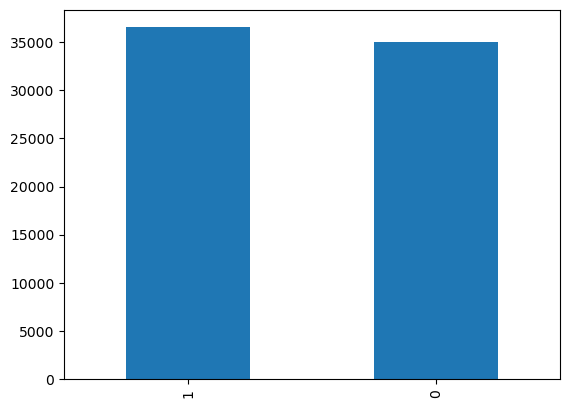

In [198]:
# Count the 1 and 0 in column label
df['label'].value_counts().plot(kind='bar')

In [199]:
df.head()

,text,label
0,law enforcement high alert following threats c...,1
2,unbelievable obama’s attorney general says cha...,1
3,bobby jindal raised hindu uses story christian...,0
4,satan 2 russia unvelis image terrifying new ‘s...,1
5,time christian group sues amazon splc designat...,1


In [200]:
print(df.shape)

(71537, 2)


## Data Split

After preprocessing, we split the data in the following manner: training/test split: 0.77/0.33. 
We chose this split ratio as the dimensions of the dataset are relatively small. Our objective was to ensure that the testing dataset is large enough to provide accurate measures.


In [201]:
# create train and test set
y = df[['label']]
x = df[['text']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (47929, 1)
X_test (23608, 1)
y_train (47929, 1)
y_test (23608, 1)


## Vectorization

In order to use Machine Learning models, we converted the text to vectors using two methods:

1. **CountVectorizer (from Sklearn package):**
   - Counts the occurrence of words, creating a matrix. Favors frequent words.
   - Generates a sparse vector, carrying less information.
   
#
2. **TfidfVectorizer (from Sklearn package):**
   - Weights words, penalizing frequent words and giving more influence to rare words.

We maximised the number of features to 10,000 in both cases to ensure equal shapes and fair comparison.
Hence, the number of rows in both datasets is 10000

In [202]:
vectoriser = TfidfVectorizer(min_df=100,
                             max_df=0.90,
                             stop_words='english',
                             max_features=10000)

X_train_tfidf = vectoriser.fit_transform(X_train["text"])
X_test_tfidf = vectoriser.transform(X_test["text"])
print('X_train_tfidf', X_train_tfidf.shape)
print('X_test_tfidf', X_test_tfidf.shape)

X_train_tfidf (47929, 10000)
X_test_tfidf (23608, 10000)


In [203]:
vectoriser = CountVectorizer(min_df = 100, ## require a word to be in at least 100 documents
                            max_df = 0.9, ## is a word appears in 90% or more of documents, then ignore, since it may be too common
                            stop_words = 'english', ## use stopwords again, although we had used it from spacy already
                            max_features = 10000)


## Now, reapply vectoriser
X_train_CV = vectoriser.fit_transform(X_train["text"]) ## use only 10000 most common words
X_test_CV = vectoriser.transform(X_test["text"])
print('X_train_CV', X_train_CV.shape)
print('X_test_CV', X_test_CV.shape)

X_train_CV (47929, 10000)
X_test_CV (23608, 10000)


## Models

For each classification model employed in this study, we utilized both TF-IDF vectorizer and CountVectorizer for text representation.

### Performance Evaluation Metrics

In addition to accuracy, we considered other relevant metrics to provide a assessment of the classification models.

### Models Overview

1. **Naive Bayes:**
   - **TF-IDF Vectorizer** 
   - **CountVectorizer**
#
2. **Logistic Regression:**
   - **TF-IDF Vectorizer**
   - **CountVectorizer**
#
3. **Random Forest:**
   - **TF-IDF Vectorizer**
   - **CountVectorizer**
#
4. **Convolutional Neural Network (CNN):**
   - **TF-IDF Vectorizer**
   - **CountVectorizer**
#
5. **Sklearn Pipeline with SGD Classifier:**
   - **TF-IDF Vectorizer**
   - **CountVectorizer**


### Naive Bayes (TF-IDF)

- **Algorithm:** Naive Bayes
- **Vectorization Method:** TF-IDF
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

### Naive Bayes (CountVectorizer)

- **Algorithm:** Naive Bayes
- **Vectorization Method:** CountVectorizer
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

In [204]:

nb_classifier_tfidf = MultinomialNB()
nb_classifier_CV = MultinomialNB()
nb_classifier_tfidf.fit(X_train_tfidf, y_train)
nb_classifier_CV.fit(X_train_CV, y_train)

nb_pred_tfidf = nb_classifier_tfidf.predict(X_test_tfidf)
nb_pred_CV = nb_classifier_CV.predict(X_test_CV)


/Users/kevin-kindlerhotmail.com/opt/anaconda3/envs/data_science/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevin-kindlerhotmail.com/opt/anaconda3/envs/data_science/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [205]:
print('CLASSIFICATION REPORT FOR NAIVE BAYES TFIDF : \n \n'+ (classification_report(y_test, nb_pred_tfidf)))
print('CLASSIFICATION REPORT FOR NAIVE BAYES CV : \n \n'+ (classification_report(y_test, nb_pred_CV)))

CLASSIFICATION REPORT FOR NAIVE BAYES TFIDF : 
 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     11693
           1       0.84      0.88      0.86     11915

    accuracy                           0.85     23608
   macro avg       0.85      0.85      0.85     23608
weighted avg       0.85      0.85      0.85     23608

CLASSIFICATION REPORT FOR NAIVE BAYES CV : 
 
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     11693
           1       0.88      0.89      0.88     11915

    accuracy                           0.88     23608
   macro avg       0.88      0.88      0.88     23608
weighted avg       0.88      0.88      0.88     23608



In [206]:
#interesting observation
pred_CV_with_tfidf = nb_classifier_tfidf.predict(X_test_CV)
print((classification_report(y_test, pred_CV_with_tfidf)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     11693
           1       0.86      0.86      0.86     11915

    accuracy                           0.86     23608
   macro avg       0.86      0.86      0.86     23608
weighted avg       0.86      0.86      0.86     23608



### Logistic Regression (TF-IDF)

- **Algorithm:** Logistic Regression
- **Vectorization Method:** TF-IDF
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

### Logistic Regression (CountVectorizer)

- **Algorithm:** Logistic Regression
- **Vectorization Method:** CountVectorizer
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

In [207]:

#logistic regression model
logistic_regression_model_tfidf = LogisticRegression(solver='liblinear', random_state=0)
logistic_regression_model_CV = LogisticRegression(solver='liblinear', random_state=0)

#tfidf
logistic_regression_model_tfidf.fit(X_train_tfidf, y_train)
logistic_regression_model_CV.fit(X_train_CV, y_train)

#predictions
tfidf_pred_log_reg_model = logistic_regression_model_tfidf.predict(X_test_tfidf)
print('CLASSIFICATION REPORT FOR LOGISTIC REGRESSION TFIDF : \n \n'+ classification_report(y_test, tfidf_pred_log_reg_model))

#predictions
CV_pred_log_reg_model = logistic_regression_model_CV.predict(X_test_CV)
print('CLASSIFICATION REPORT FOR LOGISTIC REGRESSION CV : \n \n'+ classification_report(y_test, CV_pred_log_reg_model))

/Users/kevin-kindlerhotmail.com/opt/anaconda3/envs/data_science/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevin-kindlerhotmail.com/opt/anaconda3/envs/data_science/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CLASSIFICATION REPORT FOR LOGISTIC REGRESSION TFIDF : 
 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     11693
           1       0.94      0.96      0.95     11915

    accuracy                           0.95     23608
   macro avg       0.95      0.95      0.95     23608
weighted avg       0.95      0.95      0.95     23608

CLASSIFICATION REPORT FOR LOGISTIC REGRESSION CV : 
 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     11693
           1       0.95      0.96      0.95     11915

    accuracy                           0.95     23608
   macro avg       0.95      0.95      0.95     23608
weighted avg       0.95      0.95      0.95     23608



### Random Forest (TF-IDF)

- **Algorithm:** Random Forest
- **Vectorization Method:** TF-IDF
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

### Random Forest (CountVectorizer)

- **Algorithm:** Random Forest
- **Vectorization Method:** CountVectorizer
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

In [208]:

rf1_tfidf = RandomForestClassifier(n_estimators=300, n_jobs = -1)
print(rf1_tfidf)

rf1_CV = RandomForestClassifier(n_estimators=300, n_jobs = -1)
print(rf1_CV)

s = time.time()
rf1_tfidf.fit(X_train_tfidf, y_train)
print("Time to fit RF :", time.time() - s)

y_pred_rf1 = rf1_tfidf.predict(X_test_tfidf)
print("tfidf",classification_report(y_test, y_pred_rf1))

s = time.time()
rf1_CV.fit(X_train_CV, y_train)
print("Time to fit RF :", time.time() - s)

y_pred_cv = rf1_CV.predict(X_test_CV)
print("CV",classification_report(y_test, y_pred_cv))

RandomForestClassifier(n_estimators=300, n_jobs=-1)
RandomForestClassifier(n_estimators=300, n_jobs=-1)


/var/folders/rr/kyzzwn393f731vhnzl_hk_9c0000gn/T/ipykernel_34283/3210830873.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf1_tfidf.fit(X_train_tfidf, y_train)


Time to fit RF : 39.4094181060791
tfidf               precision    recall  f1-score   support

           0       0.97      0.94      0.95     11693
           1       0.95      0.97      0.96     11915

    accuracy                           0.96     23608
   macro avg       0.96      0.96      0.96     23608
weighted avg       0.96      0.96      0.96     23608



/var/folders/rr/kyzzwn393f731vhnzl_hk_9c0000gn/T/ipykernel_34283/3210830873.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf1_CV.fit(X_train_CV, y_train)


Time to fit RF : 41.787914991378784
CV               precision    recall  f1-score   support

           0       0.96      0.95      0.96     11693
           1       0.95      0.97      0.96     11915

    accuracy                           0.96     23608
   macro avg       0.96      0.96      0.96     23608
weighted avg       0.96      0.96      0.96     23608



### Convolutional Neural Network (CountVectorizer)

- **Vectorization Method:** CountVectorizer
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

### Convolutional Neural Network (TF-IDF)

- **Vectorization Method:** TF-IDF
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

In [209]:
# CV
X_train_CV = X_train_CV.toarray()
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = X_train_CV.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.fit(X_train_CV, np.array(y_train) , epochs = 5)

pred_cv = (model.predict(X_test_CV) > 0.8)
accuracy_score(pred_cv,y_test)
classification_report(y_test, pred_cv)

Epoch 1/5
1498/1498 [==============================] - 4s 3ms/step - loss: 0.1730 - accuracy: 0.9407
Epoch 2/5
1498/1498 [==============================] - 4s 2ms/step - loss: 0.0502 - accuracy: 0.9824
Epoch 3/5
1498/1498 [==============================] - 4s 2ms/step - loss: 0.0198 - accuracy: 0.9937
Epoch 4/5
1498/1498 [==============================] - 4s 3ms/step - loss: 0.0148 - accuracy: 0.9956
Epoch 5/5
738/738 [==============================] - 1s 1ms/step


'              precision    recall  f1-score   support\n\n           0       0.96      0.96      0.96     11693\n           1       0.96      0.96      0.96     11915\n\n    accuracy                           0.96     23608\n   macro avg       0.96      0.96      0.96     23608\nweighted avg       0.96      0.96      0.96     23608\n'

In [210]:
# tfidf
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = X_train_tfidf.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.fit(X_train_tfidf, np.array(y_train) , epochs = 5)

pred_tf = (model.predict(X_test_tfidf) > 0.8)
accuracy_score(pred_tf,y_test)
classification_report(y_test, pred_tf)

Epoch 1/5
1498/1498 [==============================] - 4s 2ms/step - loss: 0.1718 - accuracy: 0.9337
Epoch 2/5
1498/1498 [==============================] - 4s 2ms/step - loss: 0.0643 - accuracy: 0.9773
Epoch 3/5
1498/1498 [==============================] - 3s 2ms/step - loss: 0.0219 - accuracy: 0.9926
Epoch 4/5
1498/1498 [==============================] - 3s 2ms/step - loss: 0.0071 - accuracy: 0.9975
Epoch 5/5
738/738 [==============================] - 1s 1ms/step


'              precision    recall  f1-score   support\n\n           0       0.95      0.97      0.96     11693\n           1       0.97      0.95      0.96     11915\n\n    accuracy                           0.96     23608\n   macro avg       0.96      0.96      0.96     23608\nweighted avg       0.96      0.96      0.96     23608\n'

### Sklearn Pipeline with SGD Classifier

- SGD Classifier (TfidfVectorizer)
- SGD Classifier (CountVectorizer)

In [211]:

def convertToString(X):
    return [str(text) for text in X]

# convert to lowercase
def convert_lowercase(column):
    for text in column:
        text = text.lower()
    return column


# remove html tags
def remove_html_tags(X):
    return [re.sub('<.*?>', '', text) for text in X]


# remove urls
def remove_url(X):
    return [re.sub('https?://\S+|www\.\S+', '', text) for text in X]

# remove punctuation
exclude = string.punctuation
def remove_punc(X):
    return [text.translate(str.maketrans('', '', exclude)) for text in X]

# remove emojis
def remove_emojis(X):
    return [emoji.demojize(text) for text in X]


# spelling correction
def remove_spelling_errors(X):
    return [TextBlob(text).correct() for text in X]

# chat word treatment
chat_words = {
    'FYI' : 'for your information',
    'LOL' : 'laugh out loud',
    'AFK' : 'away from keyboard'
}

def chat_wordsTreatment(X):
    for text in X:
        new_text = []
        for word in text.split():
            if word.upper() in chat_words:
                new_text.append(chat_words[word.upper()])
            else:
                new_text.append(word)

        return ' '.join(new_text)


# stemming
ps = PorterStemmer()
def perform_stemming(X):
    for text in X:
        new_text = [ps.stem(word) for word in text.split()]
    return ' '.join(new_text)

# tokenization
def perform_tokenization(X):
    return [word_tokenize(text) for text in X]


# remove numbers
def remove_numbers(X):
    return [re.sub(r'\d+', '', text) for text in X]

# remove unhealthy characters
def remove_unhealthy_characters(X):
    return [re.sub(r'(.)\1+', r'\1', text) for text in X]



vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=2) 
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=10000, min_df=2)
sgdClassifier = SGDClassifier(penalty='l2', alpha=1e-3, random_state=42, max_iter=1000, tol=None)

#### Stochastic Gradient Descent Classifier (TfidfVectorizer)

- **Pipeline Components:**
  - **Vectorization Method:** TF-IDF
  - **Classifier:** Stochastic Gradient Descent classifier
#
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

In [212]:

# TASK: Build a vectorizer / classifier pipeline using the previous analyzer
# the pipeline instance should stored in a variable named clf
pipelineSGD = Pipeline([
    ('convertToString', FunctionTransformer(convertToString)),
    ('convert_lowercase', FunctionTransformer(convert_lowercase)),
    ('remove_url', FunctionTransformer(remove_url)),
    ('remove_html_tags', FunctionTransformer(remove_html_tags)),
    ('remove_punc', FunctionTransformer(remove_punc)),
    ('remove_emojis', FunctionTransformer(remove_emojis)),
    ('remove_numbers', FunctionTransformer(remove_numbers)),
    ('remove_unhealthy_characters', FunctionTransformer(remove_unhealthy_characters)),

    ('vect', vectorizer),
    ('clf', sgdClassifier),
])

In [213]:

# example of X_train
# 63067 Republicans Poised For Massive Losses
# 63068 The 10 Most Important Things You Need To Know About The Midterm Elections
# 63069 The 10 Most Important Things You Need To Know About The Midterm Elections

# example of y_train
# 63067 0
# 63068 0
# 63069 1

y_train = y_train['label'].values
X_train = X_train['text'].values

pipelineSGD.fit(X_train, y_train)

Pipeline(steps=[('convertToString',
                 FunctionTransformer(func=<function convertToString at 0x7ff10dbb41f0>)),
                ('convert_lowercase',
                 FunctionTransformer(func=<function convert_lowercase at 0x7ff0b55ea1f0>)),
                ('remove_url',
                 FunctionTransformer(func=<function remove_url at 0x7ff43a874940>)),
                ('remove_html_tags',
                 FunctionTransformer(func=<function remove_html_tags at 0x7f...
                 FunctionTransformer(func=<function remove_emojis at 0x7ff43a874f70>)),
                ('remove_numbers',
                 FunctionTransformer(func=<function remove_numbers at 0x7ff4a17901f0>)),
                ('remove_unhealthy_characters',
                 FunctionTransformer(func=<function remove_unhealthy_characters at 0x7ff43a874a60>)),
                ('vect',
                 TfidfVectorizer(max_features=10000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf', SGDClassifier(alpha=0.001, random_state=42, tol=None))])

In [214]:

#predictions
sgdClassifier_model_tfidf = pipelineSGD.predict(X_test['text'].values)
print('CLASSIFICATION REPORT  : \n \n'+ classification_report(y_test, sgdClassifier_model_tfidf))

CLASSIFICATION REPORT  : 
 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     11693
           1       0.89      0.95      0.92     11915

    accuracy                           0.92     23608
   macro avg       0.92      0.92      0.92     23608
weighted avg       0.92      0.92      0.92     23608



#### Stochastic Gradient Descent Classifier (CountVectorizer)

- **Pipeline Components:**
  - **Vectorization Method:** CountVectorizer
  - **Classifier:** Stochastic Gradient Descent classifier
#
- **Performance Evaluation:** The model's performance was evaluated based on accuracy and other relevant metrics.

In [215]:
pipelineSGD = Pipeline([
    ('convertToString', FunctionTransformer(convertToString)),
    ('convert_lowercase', FunctionTransformer(convert_lowercase)),
    ('remove_url', FunctionTransformer(remove_url)),
    ('remove_html_tags', FunctionTransformer(remove_html_tags)),
    ('remove_punc', FunctionTransformer(remove_punc)),
    ('remove_emojis', FunctionTransformer(remove_emojis)),
    ('remove_numbers', FunctionTransformer(remove_numbers)),
    ('remove_unhealthy_characters', FunctionTransformer(remove_unhealthy_characters)),

    ('vect', count_vectorizer),
    ('clf', sgdClassifier),
])


pipelineSGD.fit(X_train, y_train)

Pipeline(steps=[('convertToString',
                 FunctionTransformer(func=<function convertToString at 0x7ff10dbb41f0>)),
                ('convert_lowercase',
                 FunctionTransformer(func=<function convert_lowercase at 0x7ff0b55ea1f0>)),
                ('remove_url',
                 FunctionTransformer(func=<function remove_url at 0x7ff43a874940>)),
                ('remove_html_tags',
                 FunctionTransformer(func=<function remove_html_tags at 0x7f...
                 FunctionTransformer(func=<function remove_emojis at 0x7ff43a874f70>)),
                ('remove_numbers',
                 FunctionTransformer(func=<function remove_numbers at 0x7ff4a17901f0>)),
                ('remove_unhealthy_characters',
                 FunctionTransformer(func=<function remove_unhealthy_characters at 0x7ff43a874a60>)),
                ('vect',
                 CountVectorizer(max_features=10000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf', SGDClassifier(alpha=0.001, random_state=42, tol=None))])

In [216]:
sgdClassifier_model_cv = pipelineSGD.predict(X_test['text'].values)
print('CLASSIFICATION REPORT  : \n \n'+ classification_report(y_test, sgdClassifier_model_cv))

CLASSIFICATION REPORT  : 
 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     11693
           1       0.95      0.97      0.96     11915

    accuracy                           0.96     23608
   macro avg       0.96      0.96      0.96     23608
weighted avg       0.96      0.96      0.96     23608



## ROC Curve Analysis

To further illustrate the performance of each model, ROC curves were generated for both:

- TF-IDF Vectorizer
- CountVectorizer

The ROC curves provide a visual comparison of the model performances against that of a random classifier.

### ROC Curve TF-IDF

In [217]:
models = [rf1_tfidf, logistic_regression_model_tfidf, nb_classifier_tfidf]

result_table = pd.DataFrame(columns=['classifier', 'fpr', 'tpr', 'auc'])

for model in models:
    # model = cls.fit(X_train_tf, y_train_tf)
    yproba = model.predict_proba(X_test_tfidf)[:, 1]  # Use [:, 1] to select the probabilities of the positive class

    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)

    result_table = pd.concat([result_table, pd.DataFrame({'classifier': [model.__class__.__name__],
                                                      'fpr': [fpr],
                                                      'tpr': [tpr],
                                                      'auc': [auc]})], ignore_index=True)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, pred_tf)
roc_auc = roc_auc_score(y_test, pred_tf)

# add fpr, tpr and roc_auch to the result_table
result_table = pd.concat([result_table, pd.DataFrame({'classifier': ['CNN'],
                                                      'fpr': [fpr],
                                                      'tpr': [tpr],
                                                      'auc': [roc_auc]})], ignore_index=True)
# calculate the roc curve for the sgdClassifier_model_tfidf
fpr, tpr, thresholds = roc_curve(y_test, sgdClassifier_model_tfidf)
roc_auc = roc_auc_score(y_test, sgdClassifier_model_tfidf)

# add fpr, tpr and roc_auch to the result_table
result_table = pd.concat([result_table, pd.DataFrame({'classifier': ['SGD'],
                                                      'fpr': [fpr],
                                                      'tpr': [tpr],
                                                      'auc': [roc_auc]})], ignore_index=True)

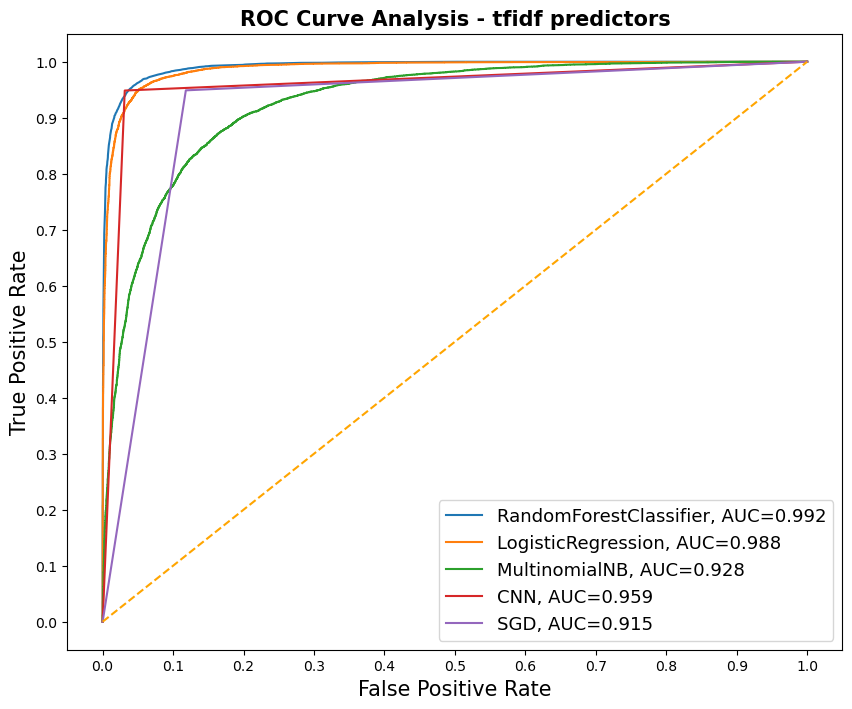

In [218]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(result_table.loc[i]['classifier'], result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis - tfidf predictors', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### ROC Curve CountVectorizer

In [219]:
models = [rf1_CV, logistic_regression_model_CV, nb_classifier_CV]

result_table = pd.DataFrame(columns=['classifier', 'fpr', 'tpr', 'auc'])

for model in models:
    # model = cls.fit(X_train_tf, y_train_tf)
    yproba = model.predict_proba(X_test_CV)[:, 1]  # Use [:, 1] to select the probabilities of the positive class

    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)

    result_table = pd.concat([result_table, pd.DataFrame({'classifier': [model.__class__.__name__],
                                                      'fpr': [fpr],
                                                      'tpr': [tpr],
                                                      'auc': [auc]})], ignore_index=True)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, pred_cv)
roc_auc = roc_auc_score(y_test, pred_cv)

# add fpr, tpr and roc_auch to the result_table
result_table = pd.concat([result_table, pd.DataFrame({'classifier': ['CNN'],
                                                      'fpr': [fpr],
                                                      'tpr': [tpr],
                                                      'auc': [roc_auc]})], ignore_index=True)

# calculate the roc curve for the sgdClassifier_model_cv
fpr, tpr, thresholds = roc_curve(y_test, sgdClassifier_model_cv)
roc_auc = roc_auc_score(y_test, sgdClassifier_model_cv)

# add fpr, tpr and roc_auch to the result_table
result_table = pd.concat([result_table, pd.DataFrame({'classifier': ['SGD'],
                                                      'fpr': [fpr],
                                                      'tpr': [tpr],
                                                      'auc': [roc_auc]})], ignore_index=True)


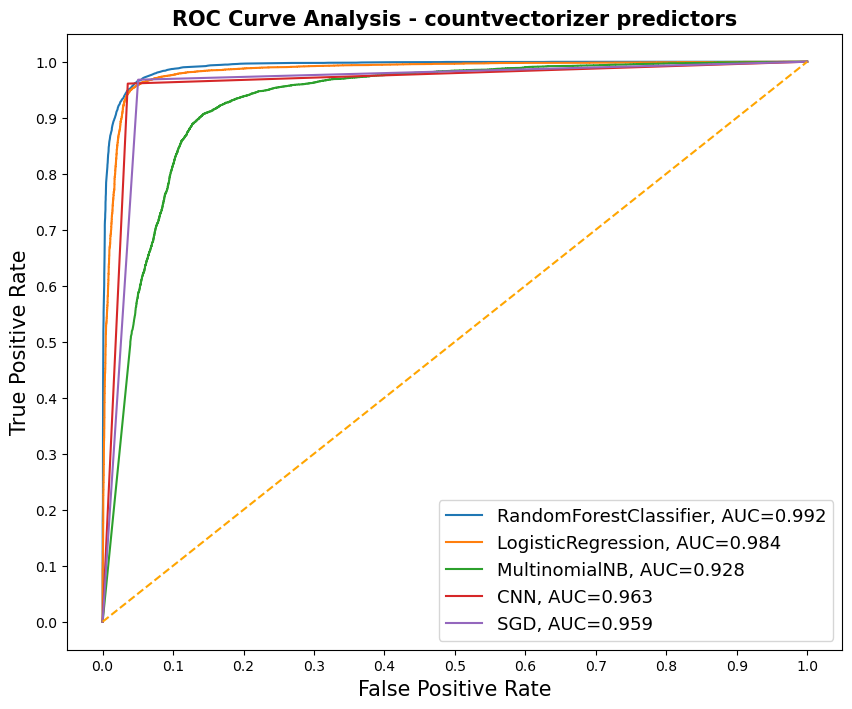

In [220]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(result_table.loc[i]['classifier'], result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis - countvectorizer predictors', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Common Misclassifications Analysis

In an effort to gain deeper insights into model performance, we conducted an analysis to identify common misclassifications. By closely examining instances where the model predictions deviated from the truth labels, we aimed to uncover patterns and potential areas for improvement.

### Methodology

We focused on instances where the model predictions were inconsistent with the actual labels, exploring both false positives and false negatives.

1. **False Positives Dictionary:**
   - For each model, we compiled a dictionary containing the indexes of false positives.
#
2. **False Negatives Dictionary:**
   - Similarly, we created another dictionary with the indexes of false negatives.

Additionally, we conducted a search for the indexes of data that were wrongly classified by all models.

In [221]:
def get_falsepos_falseneg_dict(predictions):
  #return dictionary of false postive and false negatives. Key = index (same as in df), Value = text in df

  # get the elements with false positive and false negative
  y_test_temp = y_test.copy()
  y_test_temp['pred'] = predictions
  y_test_temp.head()

  # false positive
  false_positive = y_test_temp[(y_test_temp['label'] == 0) & (y_test_temp['pred'] == 1)]
  print(false_positive.shape)

  # false negative
  false_negative = y_test_temp[(y_test_temp['label'] == 1) & (y_test_temp['pred'] == 0)]
  print(false_negative.shape)

  # match the index of false positive and false negative with the original dataset
  false_positive_dict = {}
  false_negative_dict = {}
  for idx in false_positive.index:
      if idx > len(df):
          continue
      false_positive_dict[idx] = df.iloc[idx]['text']

  for idx in false_negative.index:
      if idx > len(df):
          continue
      false_negative_dict[idx] = df.iloc[idx]['text']

  return (false_positive_dict, false_negative_dict)

In [222]:
# get the false positive and false negative dictionary for each model
# NB tfidf
false_positive_dictNB, false_negative_dictNB = get_falsepos_falseneg_dict(nb_pred_tfidf)
nb_tfidf_false_pos_indexes = list(false_positive_dictNB.keys())
print(nb_tfidf_false_pos_indexes)

# NB CV
false_positive_dictNB, false_negative_dictNB = get_falsepos_falseneg_dict(nb_pred_CV)
nb_cv_false_pos_indexes = list(false_positive_dictNB.keys())
print(nb_cv_false_pos_indexes)

# Random Forest tfidf
false_positive_dictRF, false_negative_dictRF = get_falsepos_falseneg_dict(y_pred_rf1)
rf_tfidf_false_pos_indexes = list(false_positive_dictRF.keys())
print(rf_tfidf_false_pos_indexes)

# Random Forest CV
false_positive_dictRF, false_negative_dictRF = get_falsepos_falseneg_dict(y_pred_cv)
rf_cv_false_pos_indexes = list(false_positive_dictRF.keys())
print(rf_cv_false_pos_indexes)

# CNN tfidf
false_positive_dictCNN, false_negative_dictCNN = get_falsepos_falseneg_dict(pred_tf)
cnn_tfidf_false_pos_indexes = list(false_positive_dictCNN.keys())
print(cnn_tfidf_false_pos_indexes)

# CNN CV
false_positive_dictCNN, false_negative_dictCNN = get_falsepos_falseneg_dict(pred_cv)
cnn_cv_false_pos_indexes = list(false_positive_dictCNN.keys())
print(cnn_cv_false_pos_indexes)

# Logistic Regression tfidf
false_positive_dictLogReg, false_negative_dictLogReg = get_falsepos_falseneg_dict(tfidf_pred_log_reg_model)
logreg_tfidf_false_pos_indexes = list(false_positive_dictLogReg.keys())
print(logreg_tfidf_false_pos_indexes)

# Logistic Regression CV
false_positive_dictLogReg, false_negative_dictLogReg = get_falsepos_falseneg_dict(CV_pred_log_reg_model)
logreg_cv_false_pos_indexes = list(false_positive_dictLogReg.keys())
print(logreg_cv_false_pos_indexes)

# SGD tfidf
false_positive_dictSGD, false_negative_dictSGD = get_falsepos_falseneg_dict(sgdClassifier_model_tfidf)
sgd_tfidf_false_pos_indexes = list(false_positive_dictSGD.keys())
print(sgd_tfidf_false_pos_indexes)

# SGD CV
false_positive_dictSGD, false_negative_dictSGD = get_falsepos_falseneg_dict(sgdClassifier_model_cv)
sgd_cv_false_pos_indexes = list(false_positive_dictSGD.keys())
print(sgd_cv_false_pos_indexes)

(1973, 2)
(1478, 2)
[36338, 18508, 71411, 64516, 58350, 8011, 780, 51125, 48588, 65706, 20683, 33565, 4649, 1704, 10210, 51753, 45820, 38204, 64887, 46232, 10252, 12507, 47667, 41004, 69525, 42303, 22929, 26452, 7339, 34792, 38343, 45472, 30238, 49620, 44149, 22783, 66127, 13999, 46124, 19962, 68447, 25431, 68381, 69201, 57786, 6754, 12884, 65127, 16994, 39645, 60988, 61181, 25399, 64431, 19079, 24660, 53505, 7225, 36241, 71517, 7066, 12593, 26061, 58697, 3740, 33290, 29084, 38991, 4298, 9265, 14615, 64468, 67675, 48112, 57114, 34438, 5457, 71128, 59075, 12882, 37264, 56021, 51679, 15043, 60122, 43884, 39998, 40771, 36136, 1225, 18281, 16810, 25462, 16112, 53079, 24975, 35622, 17112, 50075, 32286, 50279, 9136, 40975, 45915, 16077, 35836, 23089, 16704, 23245, 6030, 60320, 15276, 59564, 46318, 68106, 45809, 380, 8981, 6243, 64031, 25130, 66933, 34583, 67078, 23907, 43433, 31524, 38267, 46768, 58325, 51586, 30533, 7357, 71275, 61542, 63202, 52118, 39493, 49312, 47206, 27515, 11473, 62910,

### Common Misclassifications Across Models for CountVectorizer and TF_IDF

In [223]:
def compare_indexes(lists):
    if len(lists) == 0:
        return set()
    common_elements = set(lists[0])
    for lst in lists[1:]:
        common_elements.intersection_update(lst)
    return common_elements

# find those indexes in the dataset
def find_indexes(df, indexes):
    return df.iloc[list(indexes)]

# find common indexes from all CV models
common_indexes_cv = compare_indexes([nb_cv_false_pos_indexes, rf_cv_false_pos_indexes, cnn_cv_false_pos_indexes, logreg_cv_false_pos_indexes, sgd_cv_false_pos_indexes])
print(common_indexes_cv)

# find the common indexes from all tfidf models
common_indexes_tfidf = compare_indexes([nb_tfidf_false_pos_indexes, rf_tfidf_false_pos_indexes, cnn_tfidf_false_pos_indexes, logreg_tfidf_false_pos_indexes, sgd_tfidf_false_pos_indexes])
print(common_indexes_tfidf)


# find the common indexes in the dataset
result_cv = find_indexes(df, common_indexes_cv)
print("cv",result_cv)
print("cv",result_cv.shape)

# find the common indexes in the dataset
result_tfidf = find_indexes(df, common_indexes_tfidf)
print("tfidf",result_tfidf)
print("tfidf",result_tfidf.shape)

{17921, 70657, 67078, 45575, 41482, 11787, 10252, 61454, 49173, 19997, 52254, 33310, 11813, 46124, 59951, 7732, 15416, 7225, 30277, 32839, 10312, 44107, 7760, 19036, 15455, 51808, 44640, 55911, 56430, 25203, 14454, 26232, 634, 68741, 58502, 55433, 27274, 19082, 24203, 62093, 46736, 28819, 54932, 61592, 54939, 9382, 34486, 64192, 58048, 3266, 70341, 15564, 22736, 32468, 36572, 61150, 29410, 36583, 53996, 15095, 761, 28922, 54011, 9471, 26880, 67375, 16689, 13106, 63799, 63803, 11069, 55615, 24895, 40257, 33604, 57159, 37714, 25431, 24412, 63325, 7516, 23907, 11108, 46438, 55144, 63855, 54129, 22910, 7551, 54665, 17290, 50062, 67984, 20371, 43413, 27031, 62875, 51104, 61344, 64431, 53680, 21426, 65971, 9140, 38324, 68535, 20413, 62910, 50626, 29130, 30669, 58320, 46043, 478, 6112, 4079, 24053, 67577, 15869}
{17921, 70657, 70148, 45575, 41482, 10252, 43532, 61454, 56848, 4113, 33310, 64031, 11813, 46124, 15917, 59951, 26161, 7732, 15416, 7225, 63558, 32839, 44107, 12882, 71251, 52312, 190

### Create CSV for Common Misclassifications (CountVectorizer)

In [224]:
# drop the label column from the result_cv
result_cv = result_cv.drop('label', axis=1)
# Chose random 5 rows from the result_cv
print("cv",result_cv.sample(10))

result_cv = result_cv.sample(10)

# write it in a readable format
result_cv.to_csv('result_cv.csv', index=False)


cv                                                     text
29617  tyrus wong ‘bambi’ artist thwarted racial bias...
58805  fully committed nato backs new us approach afg...
33556  watch morning joe hosts wipe floor trump’s cha...
54111  french politician blames uk welfare system cal...
46792  another revision las vegas mass shooting – ami...
11148  gov rick scott florida ’will tolerate evil act...
30887  watch bundy militiaman challenge chris christi...
68552  supreme court rejects union appeal trump casin...
69316  trump administration limits government use kas...
45918  la times ’the free speech movement berkeley’ b...


### Create CSV for Common Misclassifications (TF_IDF)

In [225]:
# drop the label column from the result_tfidf
result_tfidf = result_tfidf.drop('label', axis=1)
# Chose random 5 rows from the result_tfidf
print("tfidf",result_tfidf.sample(10))

result_tfidf = result_tfidf.sample(10)
# write it in a readable format
result_tfidf.to_csv('result_tfidf.csv', index=False)

tfidf                                                     text
63848  breaking russia scandal explodes trump admin t...
4110   college republicans’ lawyer suggests deploying...
3796   egyptian rights lawyer says hell run president...
51503  black lives matter organizers hacked messages ...
20548  close “obamerica”…we tolerant…more guilty…the ...
41793  house intel panel advances nsa spying bill des...
64727  kidding lawmakers decide women go topless berk...
68552  supreme court rejects union appeal trump casin...
15515  uk royal kate makes first public appearance si...
45918  la times ’the free speech movement berkeley’ b...


# Feature Analysis Based on Log Probability

In our analysis, we examined the importance of the features in each model by identifying
the top 10 features using log probability. The log probability serves as a measure of the
importance of a feature in predicting the target variable. In logistic regression, which
yields both negative and positive log probabilities, we considered the 10 features with the
highest positive log probabilities and the 10 features with the lowest 10 log probabilities.
By comparing the 10 most important features across the models, we were able to identify
common features that are considered important.

We began by evaluating the top ten features for each model for TF-IDF and Count
Vectorization.

In [244]:
# get all the feature names
tfidf_feature_names = vectoriser.get_feature_names_out()
tfidf_feature_names = np.array(tfidf_feature_names)

cv_feature_names = vectoriser.get_feature_names_out()
cv_feature_names = np.array(cv_feature_names)

## Logistic Regression
- Top 10 features for Logistic Regression (TF-IDF)
- Top 10 features for Logistic Regression (CountVectorizer)

Text(0.5, 1.0, 'Top 10 Features for Logistic Regression (CV)')

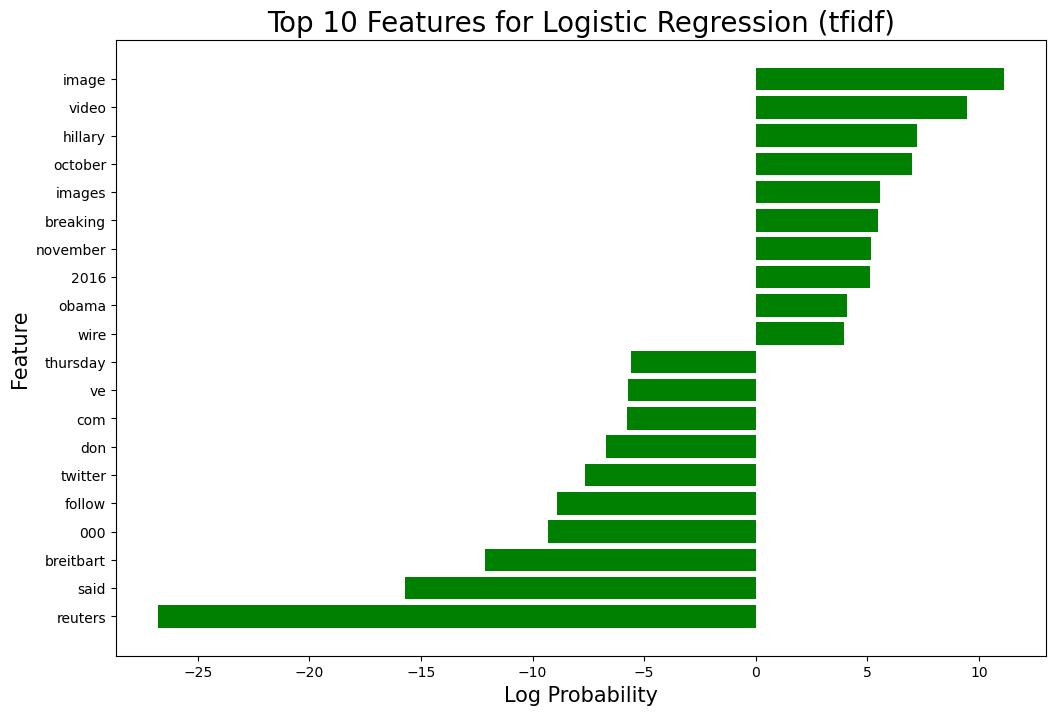

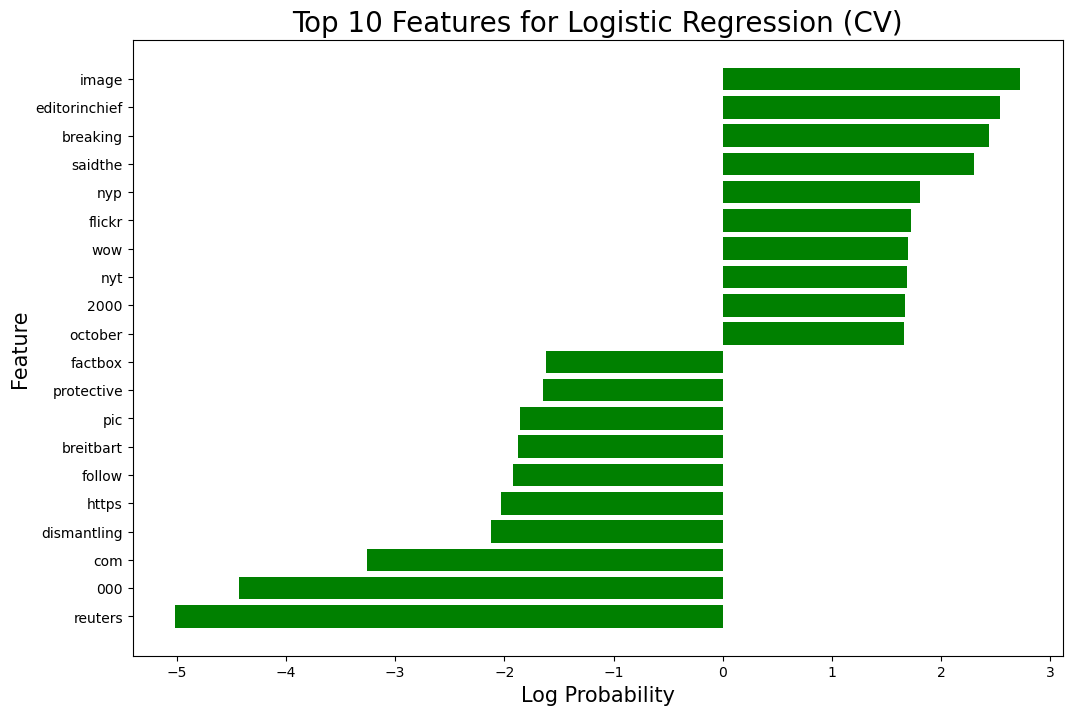

In [227]:
# Logistic Regression tfidf
# Get the log probabilities for each feature and class
log_prob = logistic_regression_model_tfidf.coef_

# Get the indices of the top 10 log probabilities for each class (binary classification)
top_neg = np.argsort(log_prob[0])[:10]
top_pos = np.argsort(log_prob[0])[-10:]

# Get the top 10 features for each class
top_neg_features = tfidf_feature_names[top_neg]
top_pos_features = tfidf_feature_names[top_pos]

# Get the top 10 log probabilities for each class

top_neg_prob = log_prob[0][top_neg]
top_pos_prob = log_prob[0][top_pos]

# Create a dataframe of the top 10 features and log probabilities for each class
top_neg_df = pd.DataFrame({'feature': top_neg_features, 'log_prob': top_neg_prob})
top_pos_df = pd.DataFrame({'feature': top_pos_features, 'log_prob': top_pos_prob})

# Concatenate the dataframes
top_neg_pos_df = pd.concat([top_neg_df, top_pos_df], axis=0)

# Sort the dataframe by log_prob
top_neg_pos_df.sort_values('log_prob', inplace=True)


# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_neg_pos_df['feature'], top_neg_pos_df['log_prob'], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for Logistic Regression (tfidf)', fontsize=20)

# Logistic Regression CV
# Get the log probabilities for each feature and class
log_prob = logistic_regression_model_CV.coef_

# Get the indices of the top 10 log probabilities for each class (binary classification)
top_neg = np.argsort(log_prob[0])[:10]
top_pos = np.argsort(log_prob[0])[-10:] 

# Get the top 10 features for each class
top_neg_features = cv_feature_names[top_neg]
top_pos_features = cv_feature_names[top_pos]

# Get the top 10 log probabilities for each class

top_neg_prob = log_prob[0][top_neg]
top_pos_prob = log_prob[0][top_pos]

# Create a dataframe of the top 10 features and log probabilities for each class
top_neg_df_cv = pd.DataFrame({'feature': top_neg_features, 'log_prob': top_neg_prob})
top_pos_df_cv = pd.DataFrame({'feature': top_pos_features, 'log_prob': top_pos_prob})

# Concatenate the dataframes
top_neg_pos_df_cv = pd.concat([top_neg_df_cv, top_pos_df_cv], axis=0)

# Sort the dataframe by log_prob
top_neg_pos_df_cv.sort_values('log_prob', inplace=True)

# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_neg_pos_df_cv['feature'], top_neg_pos_df_cv['log_prob'], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for Logistic Regression (CV)', fontsize=20)



## Random Forest
- Top 10 features for Random Forest (TF-IDF)
- Top 10 features for Random Forest (CountVectorizer)

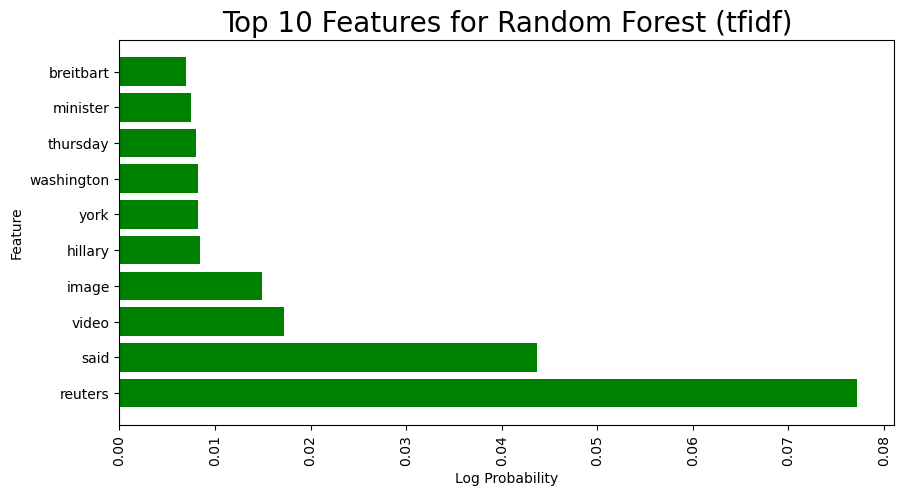

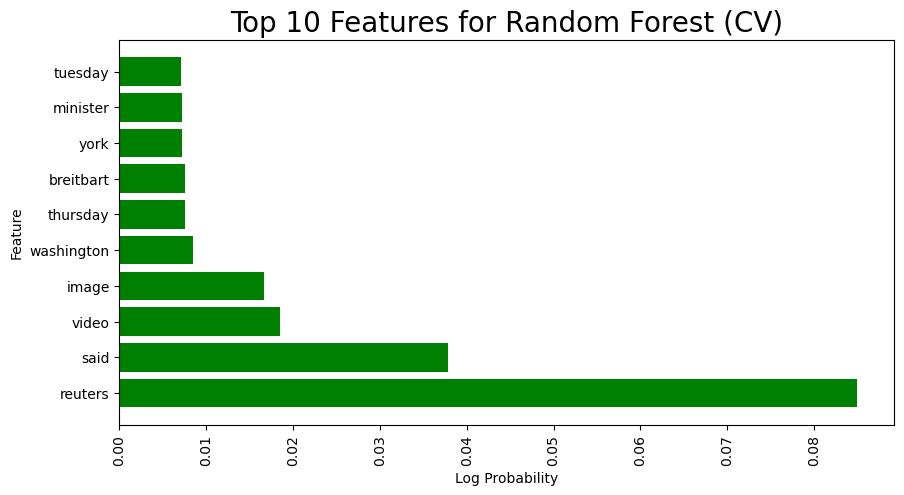

In [243]:
# Random Forest tfidf
# Get the log probabilities for each feature and class
tfidf_log_probs = rf1_tfidf.feature_importances_

# Get the indices of the top 10 log probabilities for the positive class (binary classification)
top_tfidf_indices = tfidf_log_probs.argsort()[-10:][::-1]

# Get the corresponding feature names
top_tfidf_features_random_forest = tfidf_feature_names[top_tfidf_indices]


# make a barplot where the y-axis is the feature importance and the x-axis is the feature name
plt.figure(figsize=(10, 5))
plt.barh(top_tfidf_features_random_forest, tfidf_log_probs[top_tfidf_indices], color='green')   
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.title('Top 10 Features for Random Forest (tfidf)', fontsize=20)
plt.show()

# Random Forest CV
# Get the log probabilities for each feature and class
cv_log_probs = rf1_CV.feature_importances_

# Get the indices of the top 10 log probabilities for the positive class (assuming binary classification)
top_cv_indices = cv_log_probs.argsort()[-10:][::-1]

# Get the corresponding feature names
top_cv_features_random_forest = cv_feature_names[top_cv_indices]

# make a barplot where the y-axis is the feature importance and the x-axis is the feature name
plt.figure(figsize=(10, 5))
plt.barh(top_cv_features_random_forest, cv_log_probs[top_cv_indices], color='green')
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.title('Top 10 Features for Random Forest (CV)', fontsize=20)
plt.show()

## Naive Bayes
- Top 10 features for Naive Bayes (TF-IDF)
- Top 10 features for Naive Bayes (CountVectorizer)

Text(0.5, 1.0, 'Top 10 Features for Naive Bayes (CV)')

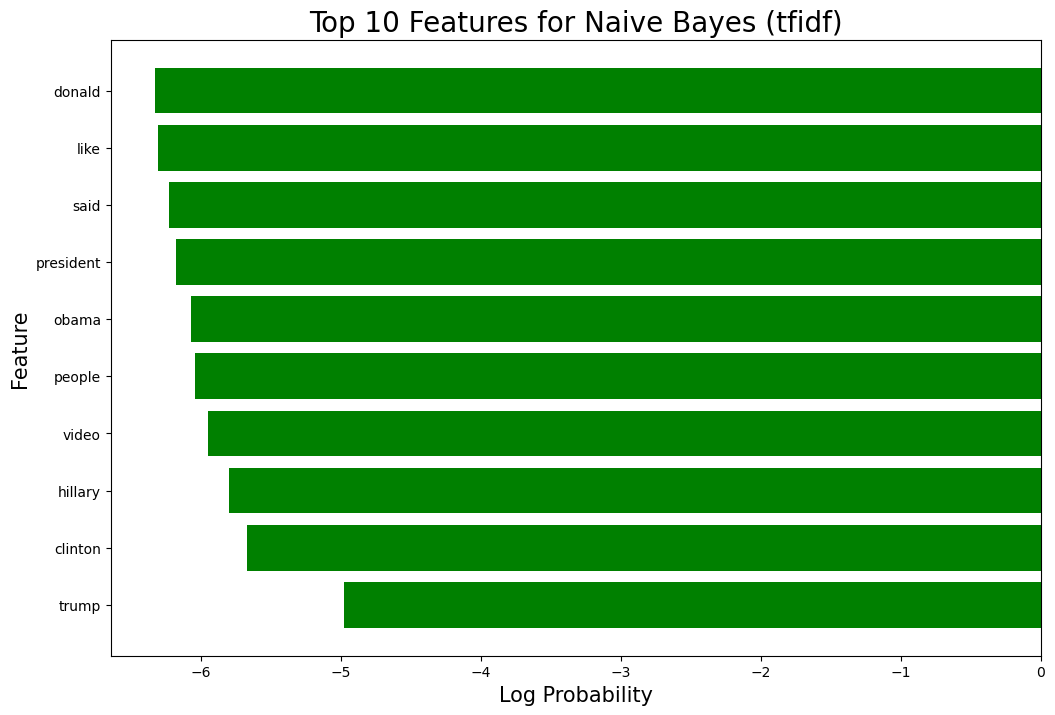

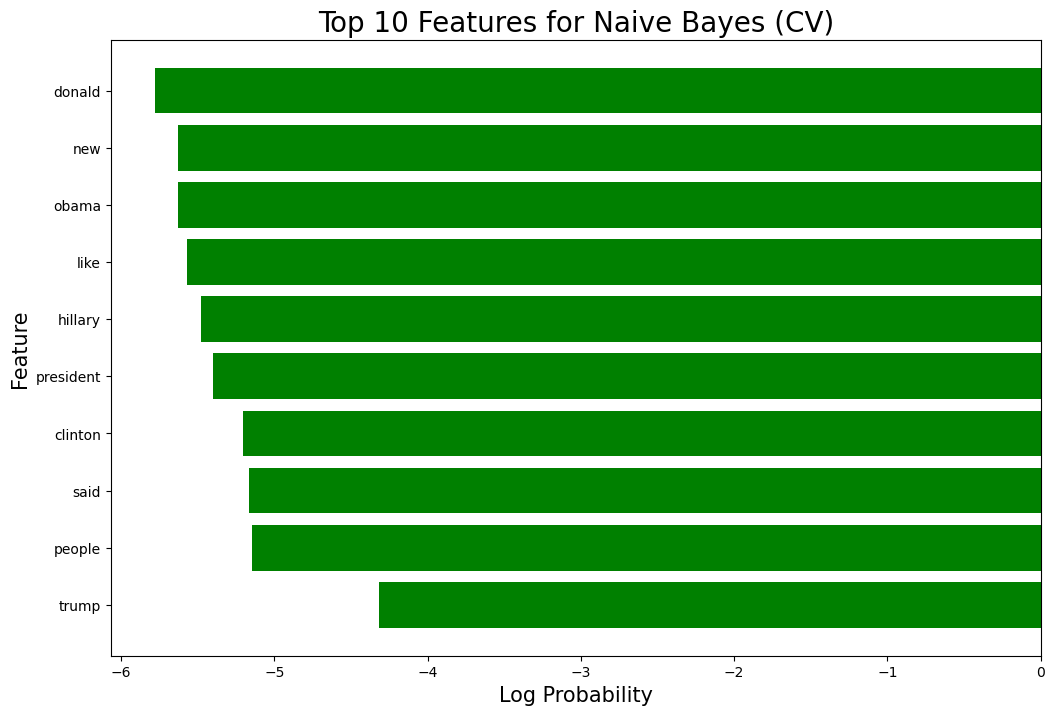

In [229]:

# Naive Bayes tfidf
# get the log probabilities for each feature and class
tfidf_log_probs = nb_classifier_tfidf.feature_log_prob_

# Get the indices of the top 10 log probabilities for the positive class
top_tfidf_indices = tfidf_log_probs[1].argsort()[-10:][::-1]

# Get the corresponding feature names
top_tfidf_features_naive_bayes = tfidf_feature_names[top_tfidf_indices]

# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_tfidf_features_naive_bayes, tfidf_log_probs[1][top_tfidf_indices], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for Naive Bayes (tfidf)', fontsize=20)


# Naive Bayes CV
# get the log probabilities for each feature and class
cv_log_probs = nb_classifier_CV.feature_log_prob_

# Get the indices of the top 10 log probabilities for the positive class
top_cv_indices = cv_log_probs[1].argsort()[-10:][::-1]

# Get the corresponding feature names
top_cv_features_naive_bayes = cv_feature_names[top_cv_indices]

# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_cv_features_naive_bayes, cv_log_probs[1][top_cv_indices], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for Naive Bayes (CV)', fontsize=20)


## CNN
- Top 10 features for CNN (TF-IDF)
- Top 10 features for CNN (CountVectorizer)

Text(0.5, 1.0, 'Top 10 Features for CNN (CV)')

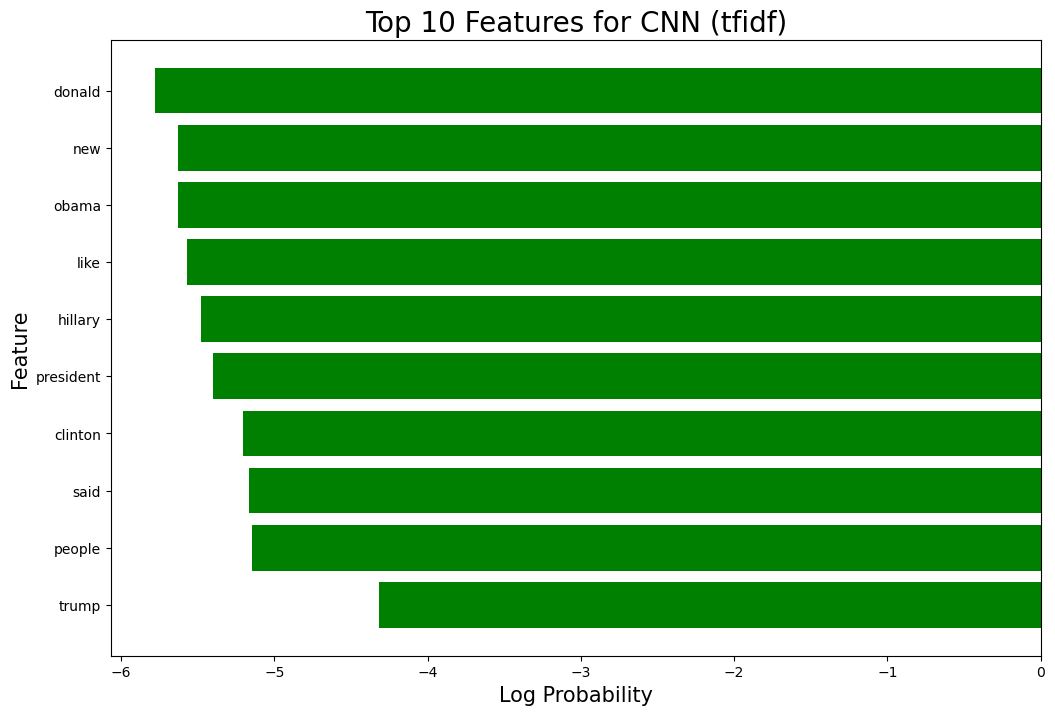

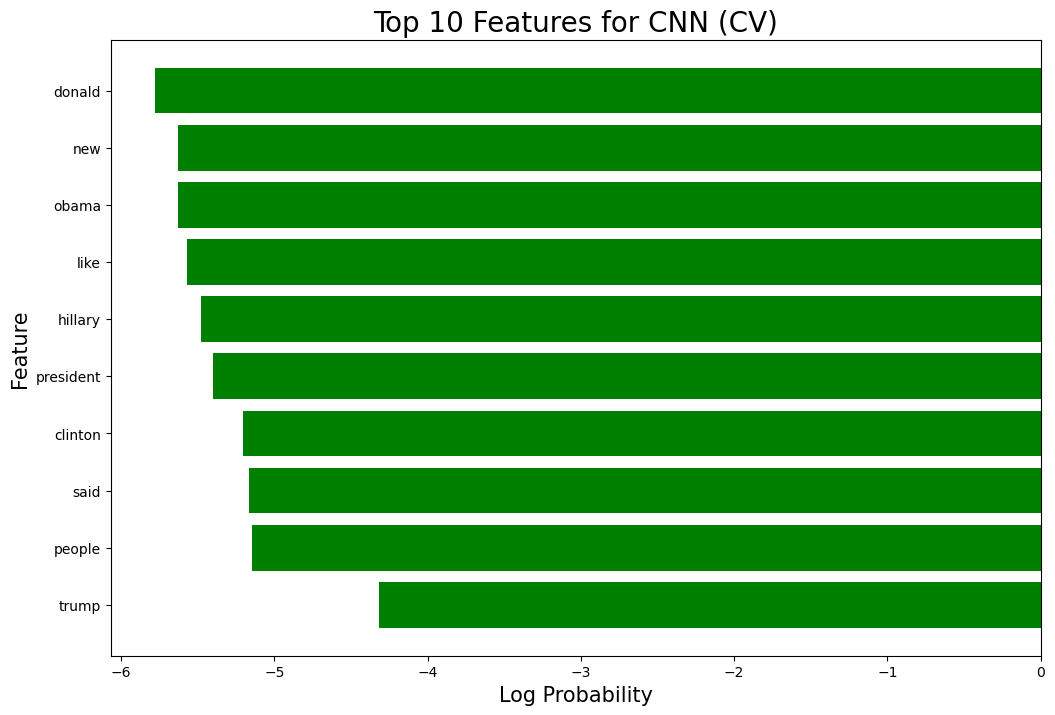

In [230]:
# CNN tfidf
# get the log probabilities for each feature and class
tfidf_log_probs = model.feature_log_prob_

# Get the indices of the top 10 log probabilities for the positive class
top_tfidf_indices = tfidf_log_probs[1].argsort()[-10:][::-1]

# Get the corresponding feature names
top_tfidf_features_cnn = tfidf_feature_names[top_tfidf_indices]

# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_tfidf_features_cnn, tfidf_log_probs[1][top_tfidf_indices], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for CNN (tfidf)', fontsize=20)


# CNN CV
# get the log probabilities for each feature and class
cv_log_probs = model.feature_log_prob_

# Get the indices of the top 10 log probabilities for the positive class
top_cv_indices = cv_log_probs[1].argsort()[-10:][::-1]

# Get the corresponding feature names
top_cv_features_cnn = cv_feature_names[top_cv_indices]

# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_cv_features_cnn, cv_log_probs[1][top_cv_indices], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for CNN (CV)', fontsize=20)


## SGD
- Top 10 features for SGD (TF-IDF)
- Top 10 features for SGD (CountVectorizer)

Text(0.5, 1.0, 'Top 10 Features for SGD (CV)')

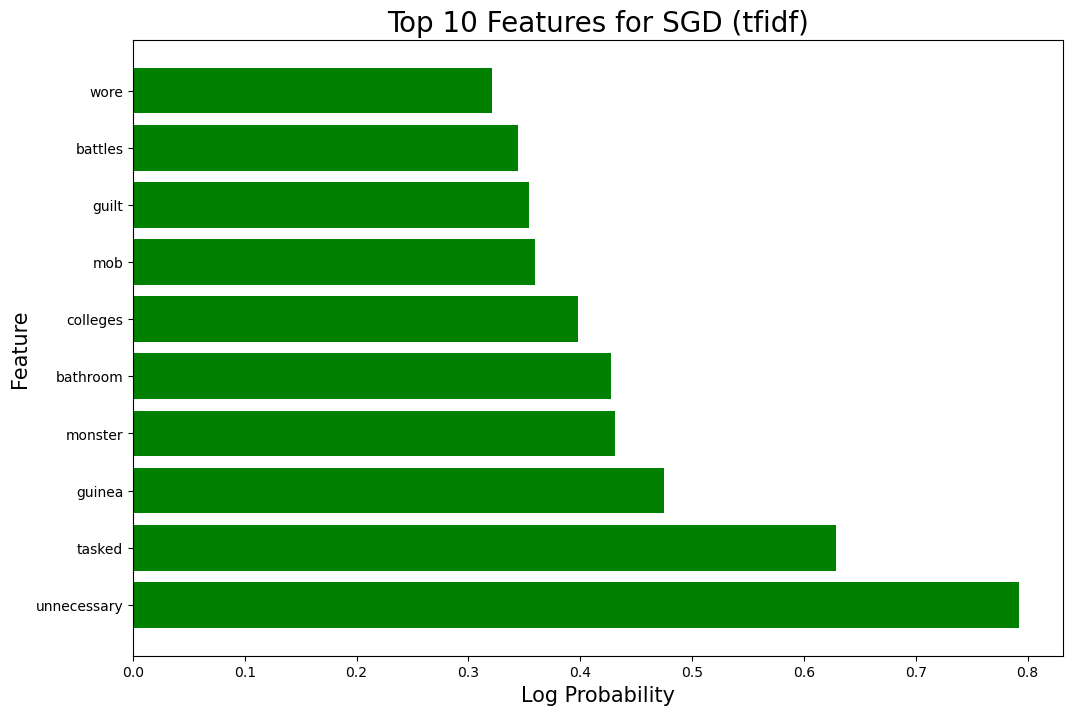

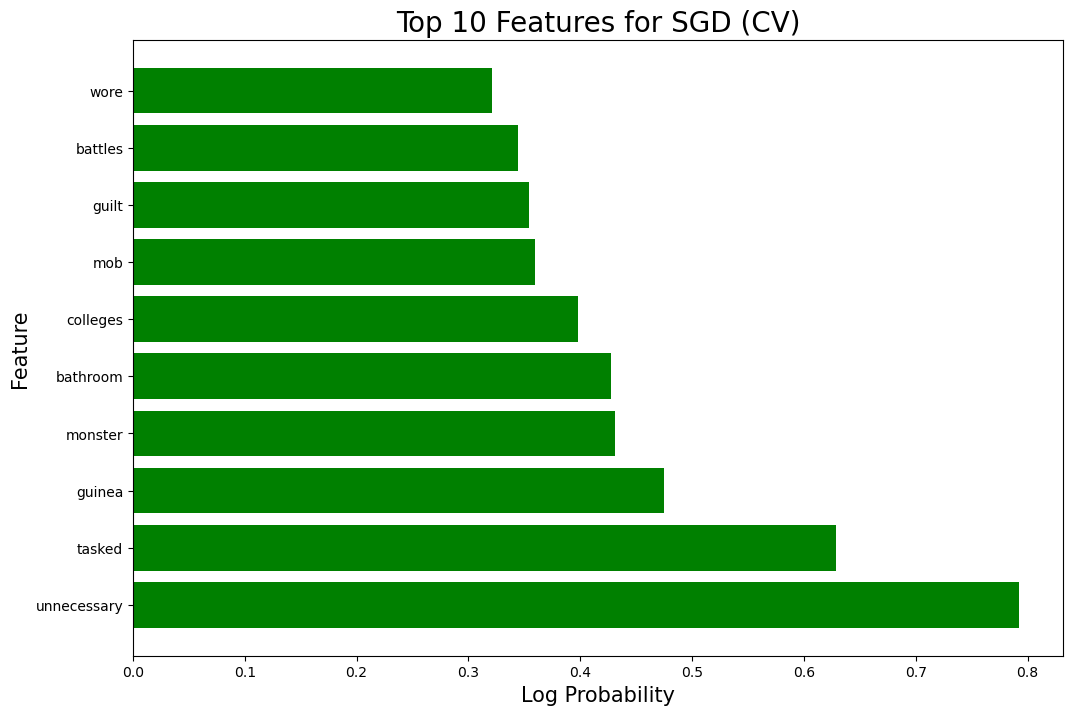

In [231]:
# SGD tfidf
# get the log probabilities for each feature and class
tfidf_log_probs = pipelineSGD.named_steps['clf'].coef_

# Get the indices of the top 10 log probabilities for the positive class
top_tfidf_indices = tfidf_log_probs[0].argsort()[-10:][::-1]



# Get the corresponding feature names
top_tfidf_features_sgd = tfidf_feature_names[top_tfidf_indices]

# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_tfidf_features_sgd, tfidf_log_probs[0][top_tfidf_indices], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for SGD (tfidf)', fontsize=20)


# SGD CV
# get the log probabilities for each feature and class
cv_log_probs = pipelineSGD.named_steps['clf'].coef_

# Get the indices of the top 10 log probabilities for the positive class
top_cv_indices = cv_log_probs[0].argsort()[-10:][::-1]

# Get the corresponding feature names
top_cv_features_sgd = cv_feature_names[top_cv_indices]

# Plot the dataframe
plt.figure(figsize=(12, 8))
plt.barh(top_cv_features_sgd, cv_log_probs[0][top_cv_indices], color='green')
plt.xlabel('Log Probability', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 10 Features for SGD (CV)', fontsize=20)






## Features in Models Scatter Plot

This scatter plot visualizes the presence of specific features in each model. 
Each point on the plot corresponds to a feature and its occurrence in a particular model.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


features:
['reuters', 'said', 'breitbart', '000', 'follow', 'twitter', 'don', 'com', 've', 'thursday', 'wire', 'obama', '2016', 'november', 'breaking', 'images', 'october', 'hillary', 'video', 'image', 'york', 'washington', 'minister', 'trump', 'clinton', 'people', 'president', 'like', 'donald', 'new', 'unnecessary', 'tasked', 'guinea', 'monster', 'bathroom', 'colleges', 'mob', 'guilt', 'battles', 'wore', 'dismantling', 'https', 'pic', 'protective', 'factbox', '2000', 'nyt', 'wow', 'flickr', 'nyp', 'saidthe', 'editorinchief', 'tuesday']


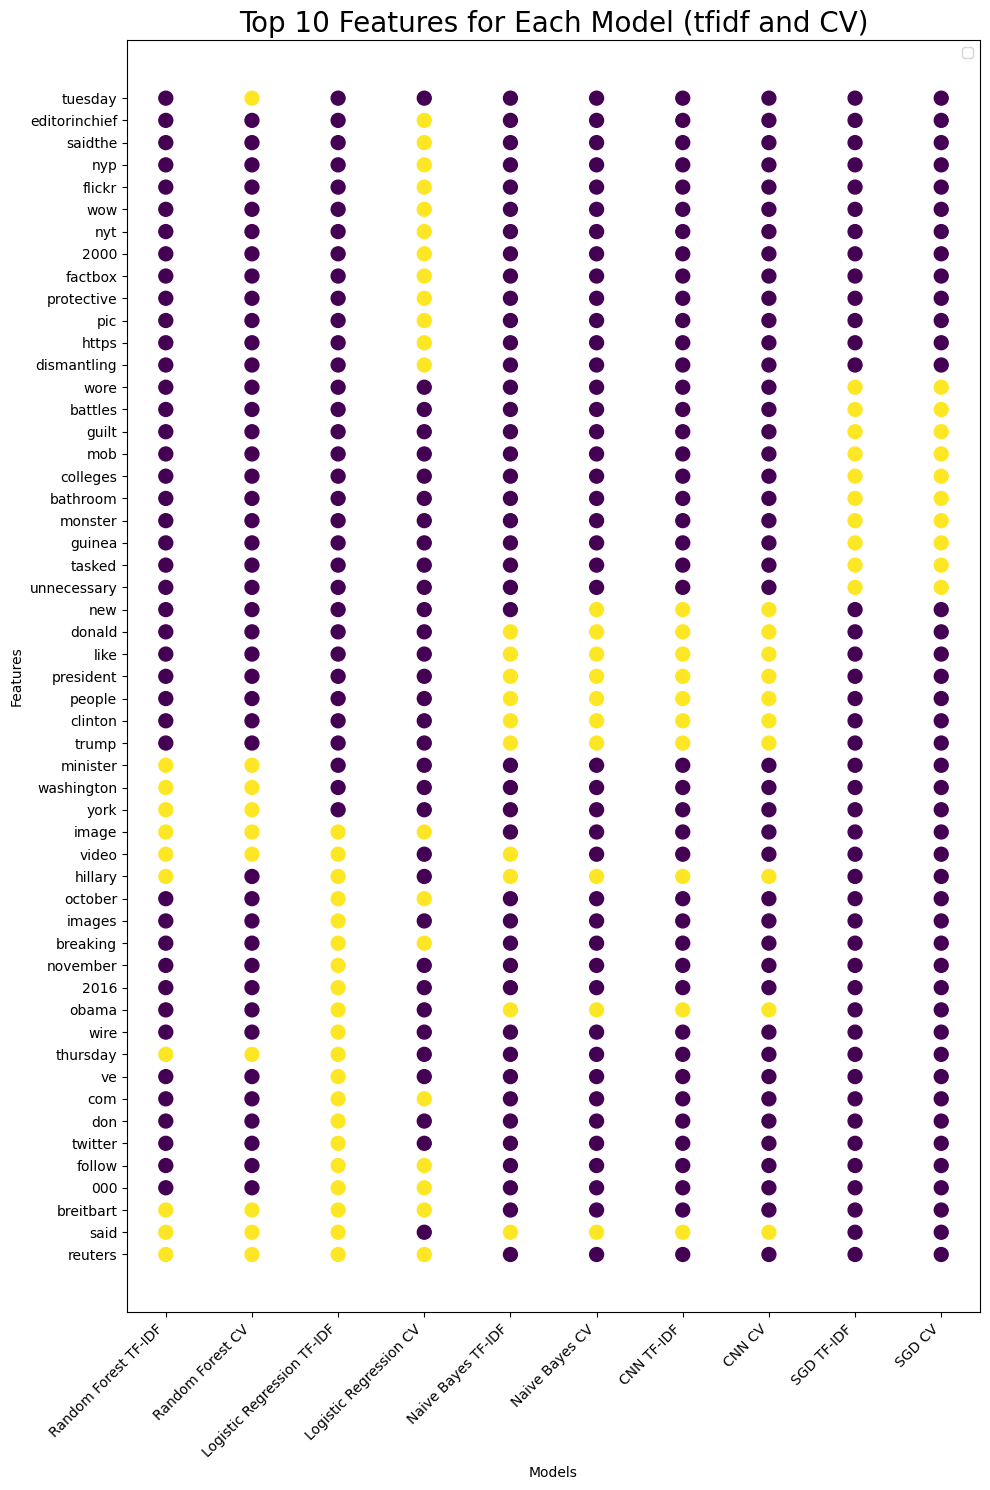

In [236]:

# List all the features on the y-axis
features = []

# add all top features from logistic regression tfidf
for feature in top_neg_pos_df['feature'].values:
    if feature not in features:
        features.append(feature)

# add all top features from random forest tfidf
for feature in top_tfidf_features_random_forest:
    if feature not in features:
        features.append(feature)

# add all top features from naive bayes tfidf
for feature in top_tfidf_features_naive_bayes:
    if feature not in features:
        features.append(feature)

# add all top features from cnn tfidf
for feature in top_tfidf_features_cnn:
    if feature not in features:
        features.append(feature)

# add all top features from sgd tfidf
for feature in top_tfidf_features_sgd:
    if feature not in features:
        features.append(feature)

# add all top features from logistic regression cv
for feature in top_neg_pos_df_cv['feature'].values:
    if feature not in features:
        features.append(feature)

# add all top features from random forest cv
for feature in top_cv_features_random_forest:
    if feature not in features:
        features.append(feature)

# add all top features from naive bayes cv
for feature in top_cv_features_naive_bayes:
    if feature not in features:
        features.append(feature)

# add all top features from cnn cv
for feature in top_cv_features_cnn:
    if feature not in features:
        features.append(feature)

# add all top features from sgd cv
for feature in top_cv_features_sgd:
    if feature not in features:
        features.append(feature)


print("features:")
print(features)

import matplotlib.pyplot as plt

# features and models
models = ['Random Forest TF-IDF', 'Random Forest CV', 'Logistic Regression TF-IDF', 'Logistic Regression CV', 'Naive Bayes TF-IDF', 'Naive Bayes CV', 'CNN TF-IDF', 'CNN CV', 'SGD TF-IDF', 'SGD CV']

# features in models
features_in_models = {
    'Random Forest TF-IDF': top_tfidf_features_random_forest,
    'Random Forest CV': top_cv_features_random_forest,
    'Logistic Regression TF-IDF': top_neg_pos_df['feature'].values,
    'Logistic Regression CV': top_neg_pos_df_cv['feature'].values,
    'Naive Bayes TF-IDF': top_tfidf_features_naive_bayes,
    'Naive Bayes CV': top_cv_features_naive_bayes,
    'CNN TF-IDF': top_tfidf_features_cnn,
    'CNN CV': top_cv_features_cnn,
    'SGD TF-IDF': top_tfidf_features_sgd,
    'SGD CV': top_cv_features_sgd,
}

# Create a scatter plot
plt.figure(figsize=(10, 15))

for model in models:
    y_values = [feature in features_in_models[model] for feature in features]
    plt.scatter([model] * len(features), features, c=y_values, cmap='viridis', marker='o', s=100)

plt.title('Top 10 Features for Each Model (tfidf and CV)', fontsize=20)
plt.xlabel('Models')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


features:
['reuters', 'said', 'breitbart', '000', 'follow', 'twitter', 'don', 'com', 've', 'thursday', 'wire', 'obama', '2016', 'november', 'breaking', 'images', 'october', 'hillary', 'video', 'image', 'york', 'washington', 'minister', 'trump', 'clinton', 'people', 'president', 'like', 'donald', 'new', 'unnecessary', 'tasked', 'guinea', 'monster', 'bathroom', 'colleges', 'mob', 'guilt', 'battles', 'wore']


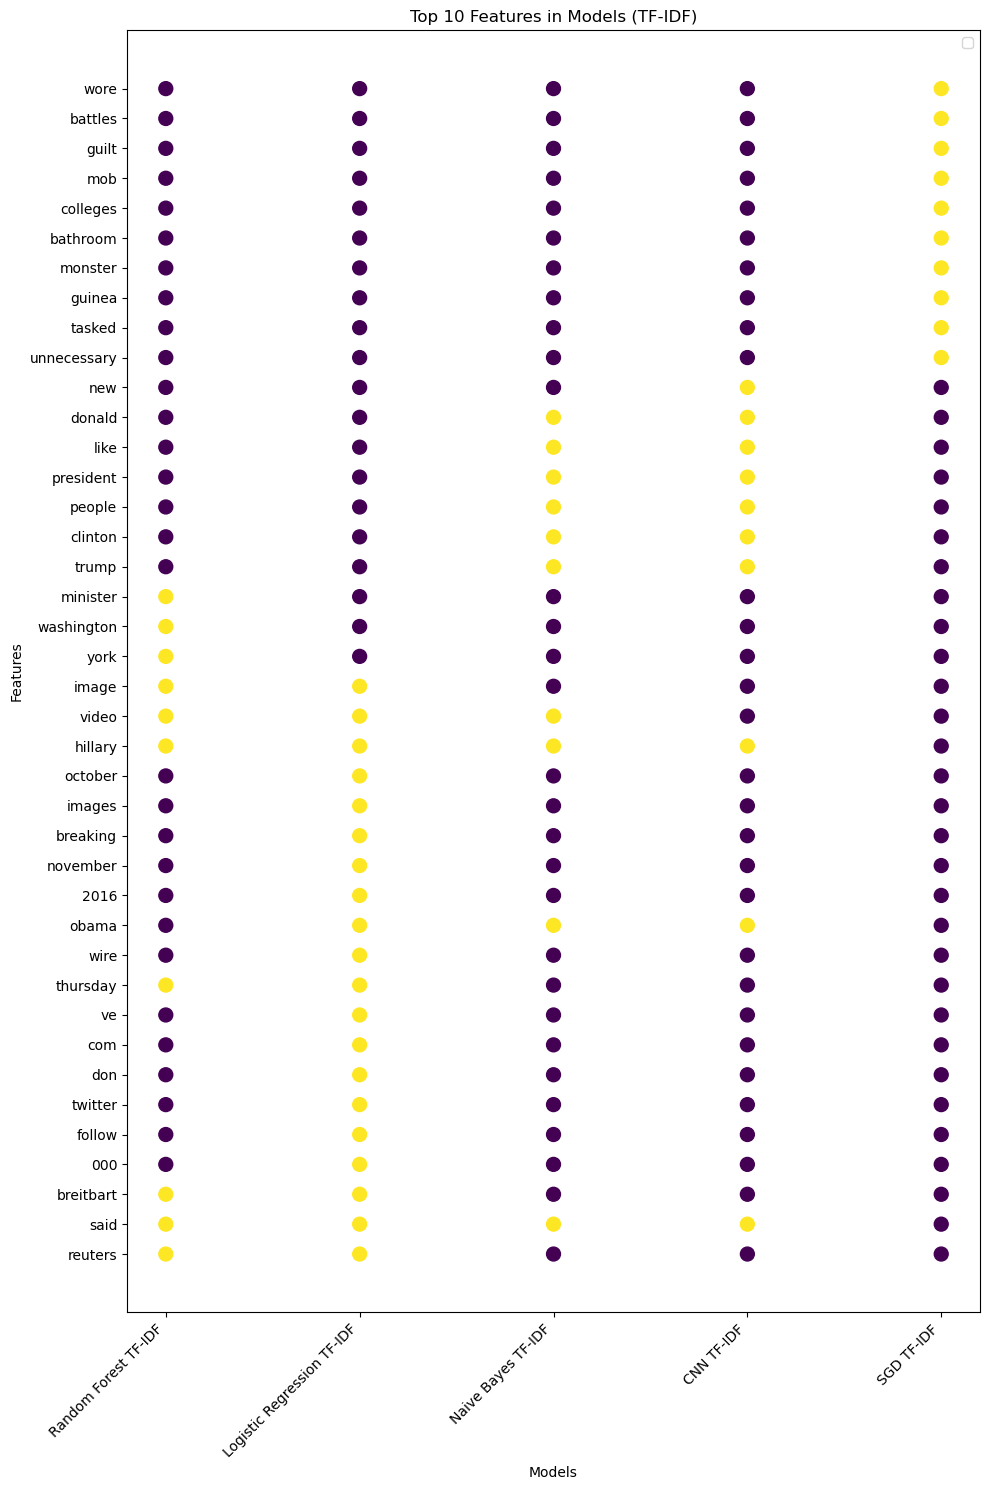

In [234]:
# List all the features on the y-axis
features = []

# add all top features from logistic regression tfidf
for feature in top_neg_pos_df['feature'].values:
    if feature not in features:
        features.append(feature)

# add all top features from random forest tfidf
for feature in top_tfidf_features_random_forest:
    if feature not in features:
        features.append(feature)

# add all top features from naive bayes tfidf
for feature in top_tfidf_features_naive_bayes:
    if feature not in features:
        features.append(feature)

# add all top features from cnn tfidf
for feature in top_tfidf_features_cnn:
    if feature not in features:
        features.append(feature)

# add all top features from sgd tfidf
for feature in top_tfidf_features_sgd:
    if feature not in features:
        features.append(feature)


print("features:")
print(features)

import matplotlib.pyplot as plt

# features and models
models = ['Random Forest TF-IDF', 'Logistic Regression TF-IDF', 'Naive Bayes TF-IDF', 'CNN TF-IDF', 'SGD TF-IDF']

# features in models
features_in_models = {
    'Random Forest TF-IDF': top_tfidf_features_random_forest,
    'Logistic Regression TF-IDF': top_neg_pos_df['feature'].values,
    'Naive Bayes TF-IDF': top_tfidf_features_naive_bayes,
    'CNN TF-IDF': top_tfidf_features_cnn,
    'SGD TF-IDF': top_tfidf_features_sgd,
}

# Create a scatter plot
plt.figure(figsize=(10, 15))

for model in models:
    y_values = [feature in features_in_models[model] for feature in features]
    plt.scatter([model] * len(features), features, c=y_values, cmap='viridis', marker='o', s=100)

plt.title('Top 10 Features in Models (TF-IDF)')
plt.xlabel('Models')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


features:
['reuters', '000', 'com', 'dismantling', 'https', 'follow', 'breitbart', 'pic', 'protective', 'factbox', 'october', '2000', 'nyt', 'wow', 'flickr', 'nyp', 'saidthe', 'breaking', 'editorinchief', 'image', 'said', 'video', 'washington', 'thursday', 'york', 'minister', 'tuesday', 'trump', 'people', 'clinton', 'president', 'hillary', 'like', 'obama', 'new', 'donald', 'unnecessary', 'tasked', 'guinea', 'monster', 'bathroom', 'colleges', 'mob', 'guilt', 'battles', 'wore']


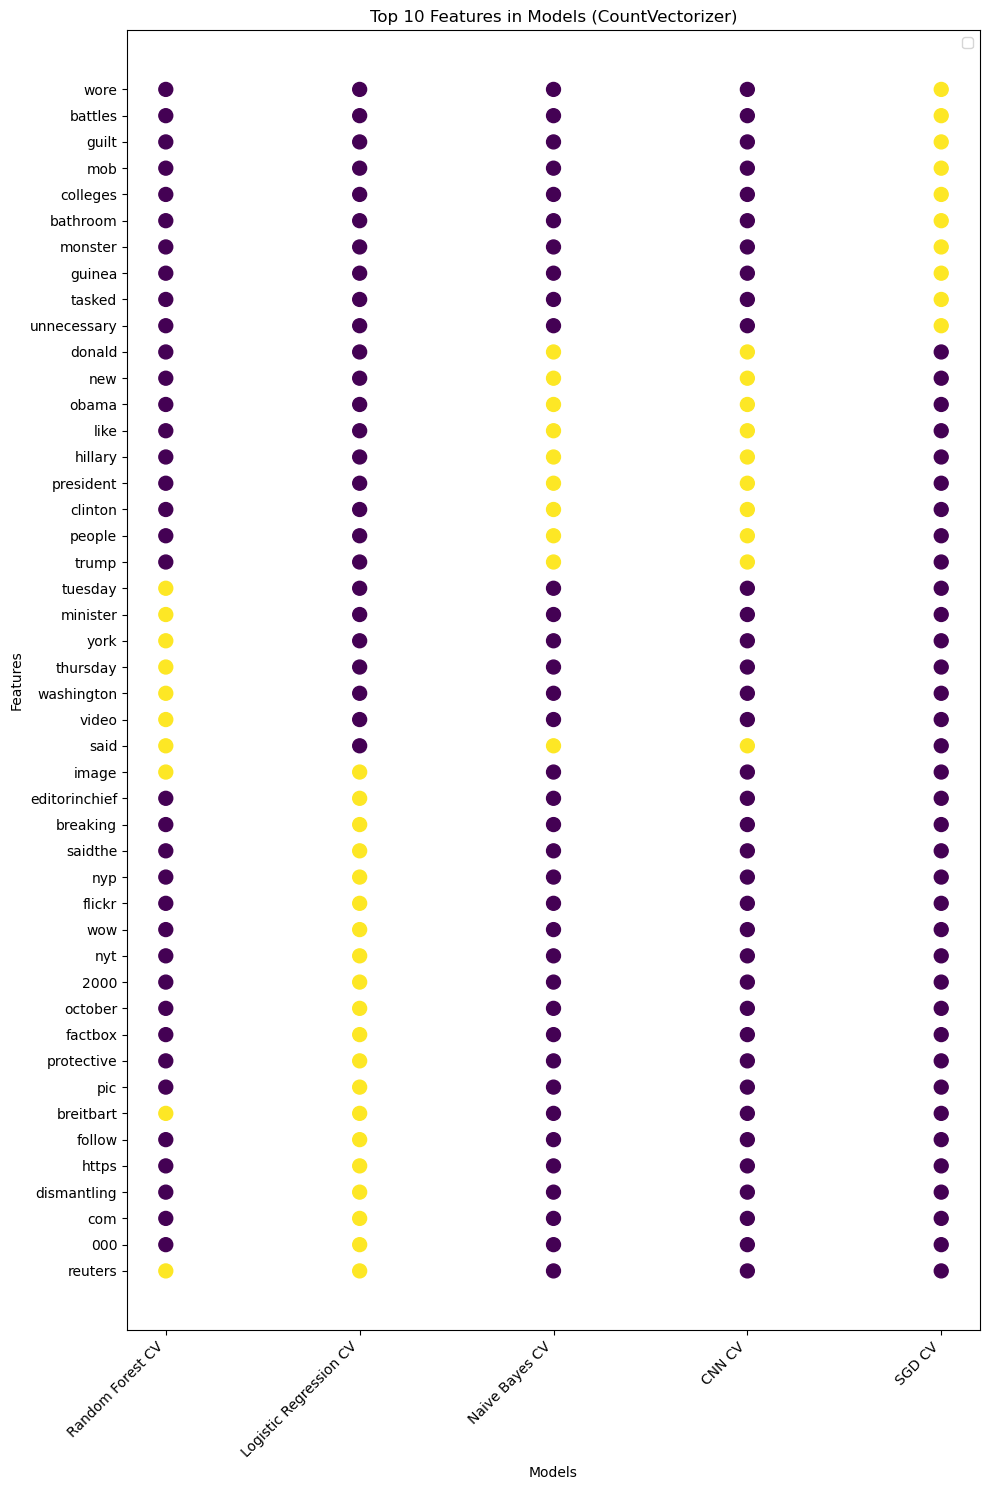

In [237]:
# List all the features on the y-axis
features = []

# add all top features from logistic regression cv
for feature in top_neg_pos_df_cv['feature'].values:
    if feature not in features:
        features.append(feature)

# add all top features from random forest cv
for feature in top_cv_features_random_forest:
    if feature not in features:
        features.append(feature)

# add all top features from naive bayes cv
for feature in top_cv_features_naive_bayes:
    if feature not in features:
        features.append(feature)

# add all top features from cnn cv
for feature in top_cv_features_cnn:
    if feature not in features:
        features.append(feature)

# add all top features from sgd cv
for feature in top_cv_features_sgd:
    if feature not in features:
        features.append(feature)


print("features:")
print(features)

import matplotlib.pyplot as plt

# features and models
models = ['Random Forest CV','Logistic Regression CV','Naive Bayes CV', 'CNN CV',  'SGD CV']

# features in models
features_in_models = {
    'Random Forest CV': top_cv_features_random_forest,
    'Logistic Regression CV': top_neg_pos_df_cv['feature'].values,
    'Naive Bayes CV': top_cv_features_naive_bayes,
    'CNN CV': top_cv_features_cnn,
    'SGD CV': top_cv_features_sgd,
}

# Create a scatter plot
plt.figure(figsize=(10, 15))

for model in models:
    y_values = [feature in features_in_models[model] for feature in features]
    plt.scatter([model] * len(features), features, c=y_values, cmap='viridis', marker='o', s=100)

plt.title('Top 10 Features in Models (CountVectorizer)')
plt.xlabel('Models')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()